# Notebook Setup

In [1]:
import pandas as pd
import seaborn as sb

from IPython.display import display

In [2]:
MEASURES_FILENAME = "./measures.csv"
CLOCK_ADJUST_RECTYPE = "CLOCK_ADJUSTED"

COSC_LIMITS_SEC_DAY = (-4, 6)

GRAPH_STYLE = "whitegrid"

In [3]:
sb.set_theme("notebook", GRAPH_STYLE)
sb.set_style()

pd.options.display.max_rows = 6

# Read Data

In [4]:
# Read the csv
measures = pd.read_csv(MEASURES_FILENAME)

# Put data back in chronological order
measures = measures.iloc[::-1].reset_index(drop=True)

In [5]:
measures = measures.rename(columns={
    "Type of record":"rectype",
    "Offset (seconds)":"offset"
})

In [6]:
measures = measures.astype({"rectype":"category"})

## Extract machine readable timestamps (utc)

In [7]:
measures["timestamp"] = pd.to_datetime(measures["Timestamp (Epoch Time)"], unit="ms")

## Create Unique Chain Numbers

In [8]:
measures["seriesID"] = measures.rectype.eq(CLOCK_ADJUST_RECTYPE).cumsum().shift(1, fill_value=0)

In [9]:
measures.groupby("seriesID").head(1)

,Timestamp (Epoch Time),Timestamp (Human Readable),rectype,offset,Series Accuracy (Seconds/day),timestamp,seriesID
0,1643217195058,Wed Jan 26 12:13:15 EST 2022,REGULAR,0.0,NaN,2022-01-26 17:13:15.058,0
36,1643395595215,Fri Jan 28 13:46:35 EST 2022,REGULAR,0.0,NaN,2022-01-28 18:46:35.215,1


In [10]:
seriesStarts = measures.groupby("seriesID").timestamp.min()
measures["adjustmentAge"] = measures.timestamp - measures.seriesID.map(seriesStarts)
measures["adjustmentDays"] = measures.adjustmentAge.dt.total_seconds() / 3600 / 24
measures




,Timestamp (Epoch Time),Timestamp (Human Readable),rectype,offset,Series Accuracy (Seconds/day),timestamp,seriesID,adjustmentAge,adjustmentDays
0,1643217195058,Wed Jan 26 12:13:15 EST 2022,REGULAR,0.0,NaN,2022-01-26 17:13:15.058,0,0 days 00:00:00,0.000000
1,1643222760664,Wed Jan 26 13:46:00 EST 2022,REGULAR,0.0,NaN,2022-01-26 18:46:00.664,0,0 days 01:32:45.606000,0.064417
2,1643226456184,Wed Jan 26 14:47:36 EST 2022,REGULAR,-1.0,NaN,2022-01-26 19:47:36.184,0,0 days 02:34:21.126000,0.107189
...,...,...,...,...,...,...,...,...,...
53,1643495033753,Sat Jan 29 17:23:53 EST 2022,REGULAR,-8.0,NaN,2022-01-29 22:23:53.753,1,1 days 03:37:18.538000,1.150909
54,1643497484386,Sat Jan 29 18:04:44 EST 2022,REGULAR,-9.0,NaN,2022-01-29 23:04:44.386,1,1 days 04:18:09.171000,1.179273
55,1643513976086,Sat Jan 29 22:39:36 EST 2022,REGULAR,-10.0,NaN,2022-01-30 03:39:36.086,1,1 days 08:53:00.871000,1.370149


# Plot Offsets

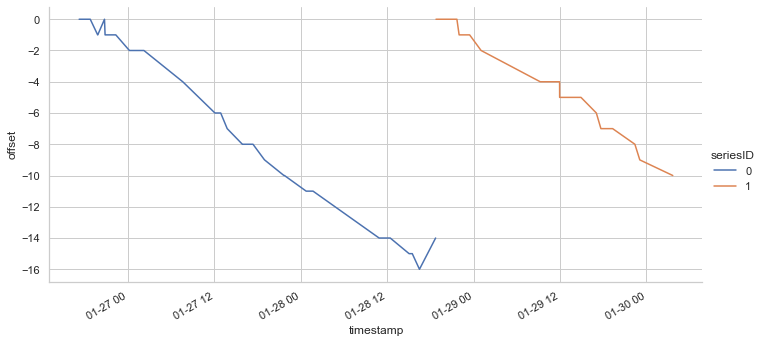

In [11]:
f = sb.relplot(data=measures, x="timestamp", y="offset", hue="seriesID", kind="line", aspect=2)
f.figure.autofmt_xdate()

# Plot Superposed Adjustment Cycles

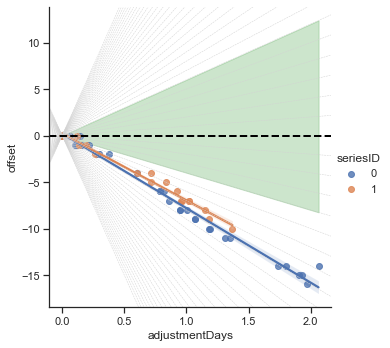

In [12]:
sb.set_style("ticks")
f = sb.lmplot(data=measures, x="adjustmentDays", y="offset", hue="seriesID")

maxDays = measures.adjustmentDays.max()
minOffset = measures.offset.min()

limitsX = [0, maxDays]
limitYMin = [0, maxDays * COSC_LIMITS_SEC_DAY[0]]
limitYMax = [0, maxDays * COSC_LIMITS_SEC_DAY[1]]

f.ax.fill_between(limitsX, limitYMin, limitYMax, color="green", alpha=0.2, zorder=0)

for i in range(-30,31):
    f.ax.axline((0,0), (1/100, i/100), c="lightgrey", lw=0.5, ls="--")

f.ax.axhline(0, c="black", lw=2, ls="--")